# Model Bias Monitoring with AWS SageMaker Clarity

This Jupyter notebook shows how to perform model bias observability with AWS SageMaker (based on [docs](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/fairness_and_explainability/SageMaker-Model-Monitor-Fairness-and-Explainability.html))

1. <a href="#1.-Configuration">Configuration</a>
1. <a href="#2.-Dataset">Dataset</a> description
1. <a href="#3.-Deploying-model">Deploying model</a> for ML Observability
1. <a href="#4.-Setting-up-monitoring-job">Setting up monitoring job</a> - Creates Monitoring tasks by creating baseline and scheduling regular monitoring
1. <a href="#5.-Generating-traffic">Generate traffic</a> - Provides traffic (examples and ground truth) to the endpoint based on which bias metrics will be calculated
1. <a href="#6.-Cleaning-up">Cleaning up</a> - Removes all the created resources.

Prerequisites:

- Existing Roles with all needed permissions (S3, SageMaker, etc.);
- Configured SageMaker Domain;
- SageMaker Studio user.

One can use SageMaker Studio (Jupyter-like environment) to run this notebook. To do that, follow the next steps:

1. Run the SageMaker Studio
2. Clone this repository (https://github.com/griddynamics/gd-ml-observability.git)


<img alt="Add the repository.png" src="images/add_the_repository.jpg" style="height:100px"/>

<img alt="repository.png" src="images/repository.jpg" style="height:300px; margin: auto"/>

3. Run this notebook cell by cell paying attention to comments

### Background

A computer system powered by machine learning model might contain bias, i.e., discriminate against certain individuals or groups of individuals. The models learn from data, so it might memorize bias that appears in that data. Biased judgements impact on people badly and unfairly, and automation of such process could lead to disasterous consequences. Hence, people developing such systems must be aware of it, and be able to address biased models. [\*](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-data-bias.html)

AWS provides SageMaker Clarity services to identify and measure bias level by calculating [pre-training](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-data-bias.html) and [post-training](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-post-training-bias.html) bias metrics based on model input, output, and ground truth information gathered and added during monitoring process and comparing it to calculated in advance baseline metrics.

## 1. Configuration

In [2]:
!pip install --upgrade boto3


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


### Importing necessary libraries

In [3]:
import copy
import json
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker

from datetime import datetime

from IPython.display import display
from sagemaker import get_execution_role, image_uris
from sagemaker.clarify import (
    BiasConfig,
    DataConfig,
    ModelConfig,
    ModelPredictedLabelConfig,
)
from sagemaker.model import Model
from sagemaker.model_monitor import (
    BiasAnalysisConfig,
    CronExpressionGenerator,
    DataCaptureConfig,
    EndpointInput,
    ModelBiasMonitor,
)
from sagemaker.s3 import S3Downloader, S3Uploader


### Setting up necessary variables and constants

In [4]:
sagemaker_session = sagemaker.session.Session()
sagemaker_client = sagemaker_session.sagemaker_client
sagemaker_runtime_client = sagemaker_session.sagemaker_runtime_client
role =  get_execution_role()

DATA_BUCKET = 'adp-rnd-ml-datasets'
# Change the following bucket names if you want to run this code outside GridDynamics to the ones you have accees to.
STAGE_BUCKET = 'adp-rnd-ml-stage'
MODEL_BUCKET = 'adp-rnd-ml-models'
MODEL_PATH = f"s3://{MODEL_BUCKET}/xgboost-for-loan-default-data/output/xgboost-for-loan-default-data-2023-02-24-08-18-30-629/output/model.tar.gz"
DATASET_PATH = f"s3://{DATA_BUCKET}/loan_default/dataset.zip"
TEST_PATH = f"s3://{DATA_BUCKET}/loan_default/test.csv"
VALIDATION_PATH = f"s3://{DATA_BUCKET}/loan_default/eval.csv"

NOW = datetime.now()

%matplotlib inline
plt.style.use("seaborn-pastel")

## 2. Dataset

<a href="https://www.kaggle.com/datasets/yasserh/loan-default-dataset">Loan Default Dataset</a> was used for this work. It's published under CC0: Public Domain license, hence both non-profit, and commercial usage is permitted. It consists of 33 features of different types (categorical/binary, continuous/decimal) including the binary target feature **Status** which is used for the classification task. The dataset has set of columns with missing values, which needs to be handled before using with the machine learning models. It has outliers, which needs to be handled, it is likely to have data leakege, which solves the task for 100% accuracy, so such features are to remove.

### Basic EDA

In [5]:
dataset = pd.read_csv(DATASET_PATH, compression='zip', index_col='ID')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148670 entries, 24890 to 173559
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       148670 non-null  int64  
 1   loan_limit                 145326 non-null  object 
 2   Gender                     148670 non-null  object 
 3   approv_in_adv              147762 non-null  object 
 4   loan_type                  148670 non-null  object 
 5   loan_purpose               148536 non-null  object 
 6   Credit_Worthiness          148670 non-null  object 
 7   open_credit                148670 non-null  object 
 8   business_or_commercial     148670 non-null  object 
 9   loan_amount                148670 non-null  int64  
 10  rate_of_interest           112231 non-null  float64
 11  Interest_rate_spread       112031 non-null  float64
 12  Upfront_charges            109028 non-null  float64
 13  term                     

In [6]:
# Few instances of dataset
dataset.head()

,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
ID,,,,,,,,,,,,,,,,,,,,,
24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [7]:
# Shows statistics of numerical features
dataset.describe() 

,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


Here one can get intuition of sensitive features distribution before preprocessing (handling missing values, and one-hot encoding):

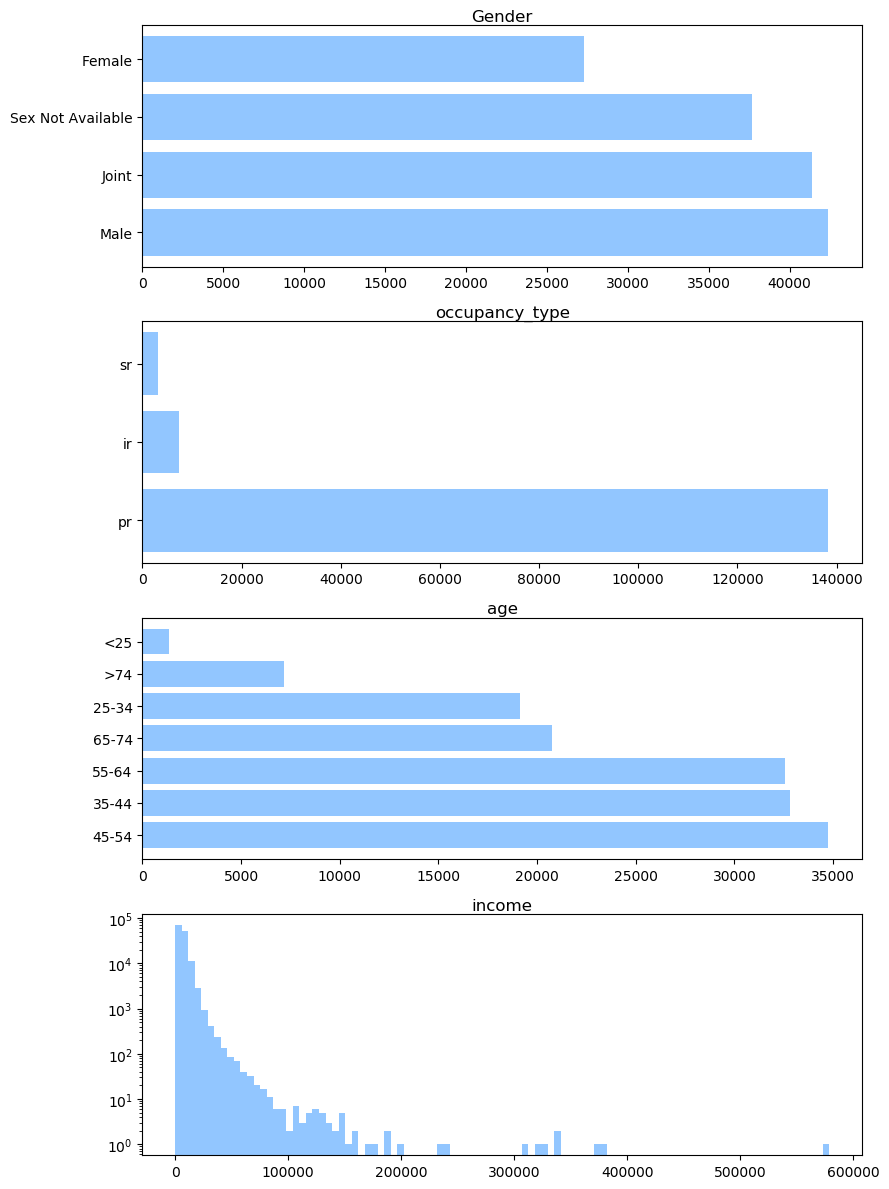

In [8]:
SENSITIVE_COLUMNS = ['Gender', 'occupancy_type', 'age'] # + "income", but processed separately, as different type

figs, axs = plt.subplots(4, 1, figsize=(9, 12))
for i, column in enumerate(SENSITIVE_COLUMNS):
    data = dataset[column].value_counts()
    axs[i].barh(data.index, data.values)
    axs[i].set_title(column, pad=3)

axs[-1].hist(dataset['income'], bins=100, log=True)
axs[-1].set_title('income', pad=3)
plt.tight_layout()

## 3. Deploying model

Setting up data capture config to be able to monitor model bias based on the stored data

In [9]:
container = sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "1.5-1")

prefix = f'xgboost-for-loan-default-data-{NOW:%Y-%m-%d}'
s3_key = f"s3://{STAGE_BUCKET}/{prefix}"
print(f"S3 key: {s3_key}")
s3_capture_upload_path = f"{s3_key}/datacapture"

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)

S3 key: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28


Creating and deploying Model instance fox XGBoost classifier model which then will be used for ML Observability

In [10]:
xgb_model_name = f'loan-default-xgboost-{NOW:%Y-%m-%d}'
xgb_endpoint_name = f'{xgb_model_name}-endpoint'

xgb_model = Model(
    image_uri=container,
    model_data=MODEL_PATH,
    role=role,
    name=xgb_model_name,
    sagemaker_session=sagemaker_session
)

xgb_model.deploy(
    endpoint_name=xgb_endpoint_name,
    model_name=xgb_model_name,
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge",
    data_capture_config=data_capture_config,
)

-------!

### Results

As a result, one will get a Load Default model and an endpoint. You can find them in the AWS Console -> SageMaker -> Governance -> Model cards. The new model should appear with specified endpoint (and that's all for now)

<img alt="governance.png" src="images/governance.jpg">

\* here and later all screenshots are given for illustration. You can have different names/values

## 4. Setting up monitoring job

In [11]:
monitoring_prefix = f"{prefix}/ClarifyModelMonitor-{NOW:%Y-%m-%d}"

ground_truth_upload_path = f"{s3_key}/ground_truth_data"
s3_report_path = f"{s3_key}/reports"

print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

baseline_results_uri = f"{s3_key}/baselining"
print(f"Baseline results uri: {baseline_results_uri}")
model_bias_baselining_job_result_uri = f"{baseline_results_uri}/model_bias"


Capture path: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/datacapture
Ground truth path: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/ground_truth_data
Report path: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/reports
Baseline results uri: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/baselining


After preprocessing some columns were dropped, some were transformed into numerical by converting binary columns to 0/1 columns, and some were one-hot encoded:

In [12]:
TARGET_COLUMN = 'Status'
ALL_INPUT_COLUMNS = ['Status', 'loan_amount', 'term', 'income', 'Credit_Score', 'loan_limit',
       'approv_in_adv', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'Secured_by', 'co-applicant_credit_type',
       'submission_of_application', 'Gender_Female', 'Gender_Joint',
       'Gender_Male', 'Gender_Sex Not Available', 'loan_purpose_p1',
       'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4',
       'occupancy_type_ir', 'occupancy_type_pr', 'occupancy_type_sr',
       'total_units_1U', 'total_units_2U', 'total_units_3U', 'total_units_4U',
       'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74',
       'age_gt74', 'age_lt25']
DATASET_TYPE = "text/csv"

Creating and configuring monitor:

In [13]:
model_bias_monitor = ModelBiasMonitor(
    role=role,
    sagemaker_session=sagemaker_session,
    max_runtime_in_seconds=1800,
)

model_bias_data_config = DataConfig(
    s3_data_input_path=VALIDATION_PATH,
    s3_output_path=model_bias_baselining_job_result_uri,
    label=TARGET_COLUMN,
    headers=ALL_INPUT_COLUMNS,
    dataset_type=DATASET_TYPE,
)

Setting up facets - sensitive features based on which model bias will be calculated and later observed

In [14]:
FACET_COLUMNS_VALUES = {
    facet: values 
    for facet, values
    in zip(
        [
            'Gender_Female', 'Gender_Joint', 'Gender_Male', 'Gender_Sex Not Available', 
            'income',
            'occupancy_type_ir', 'occupancy_type_pr', 'occupancy_type_sr',
            'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'age_gt74', 'age_lt25'
        ],
        [
            [1], [1], [1], [1], # Gender - Binary data, assessing only positive values of one-hot-encoded features
            [25000.], # income - threshold splitting into 2 groups with income level less and more then 30000.0 
            [1], [1], [1], # occupancy_pyte - Binary data, assessing only positive values of one-hot-encoded features 
            [1], [1], [1], [1], [1], [1], [1] # age -  Binary data, assessing only positive values of one-hot-encoded features
        ]
    )
}

In [15]:
model_bias_config = BiasConfig(
    # Loan default value of target feature Status is 1. 
    # Thus, we'll choose 0 as positive outcome, so Bias metrics could make sense
    label_values_or_threshold=[0],
    facet_name=list(FACET_COLUMNS_VALUES.keys()),
    facet_values_or_threshold=list(FACET_COLUMNS_VALUES.values()),
)

In [16]:
model_predicted_label_config = ModelPredictedLabelConfig(probability_threshold=.5)
model_config = ModelConfig(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    content_type=DATASET_TYPE,
    accept_type=DATASET_TYPE,
    endpoint_name=xgb_endpoint_name,
)

### Creating baseline

In [17]:
model_bias_monitor.suggest_baseline(
    model_config=model_config,
    data_config=model_bias_data_config,
    bias_config=model_bias_config,
    model_predicted_label_config=model_predicted_label_config,
)

model_bias_monitor.latest_baselining_job.wait(logs=False)
model_bias_constraints = model_bias_monitor.suggested_constraints()

INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2023-02-28-15-46-10-999


.............................................................................!


In [18]:
print(f"ModelBiasMonitor suggested constraints: {model_bias_constraints.file_s3_uri}")
print("Visualizing part of suggested constrains:")
suggested_constrains = json.loads(S3Downloader.read_file(model_bias_constraints.file_s3_uri))
res = {k: v for k, v in suggested_constrains.items() if 'metrics' not in k}
res['post_training_bias_metrics'] = dict(label='Status', facets=dict(Gender_Female=suggested_constrains['post_training_bias_metrics']['facets']['Gender_Female']))
res['pre_training_bias_metrics'] = dict(label='Status', facets=dict(Gender_Female=suggested_constrains['pre_training_bias_metrics']['facets']['Gender_Female']))
res['post_training_bias_metrics']['facets']['income'] = '...'
res['pre_training_bias_metrics']['facets']['income'] = '...'
print(json.dumps(res, indent=4))

ModelBiasMonitor suggested constraints: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/baselining/model_bias/analysis.json
Visualizing part of suggested constrains:
{
    "version": "1.0",
    "post_training_bias_metrics": {
        "label": "Status",
        "facets": {
            "Gender_Female": [
                {
                    "value_or_threshold": "1",
                    "metrics": [
                        {
                            "name": "AD",
                            "description": "Accuracy Difference (AD)",
                            "value": -0.012274862880233273
                        },
                        {
                            "name": "CDDPL",
                            "description": "Conditional Demographic Disparity in Predicted Labels (CDDPL)",
                            "value": null,
                            "error": "Group variable is empty or not provided"
                        },
                        {
    

### Setting up monitoring job

In [19]:
model_bias_analysis_config = None
if not model_bias_monitor.latest_baselining_job:
    model_bias_analysis_config = BiasAnalysisConfig(
        model_bias_config,
        headers=all_headers,
        label=label_header,
    )

model_bias_monitor.create_monitoring_schedule(
    analysis_config=model_bias_analysis_config,
    output_s3_uri=s3_report_path,
    endpoint_input=EndpointInput(
        endpoint_name=xgb_endpoint_name,
        destination="/opt/ml/processing/input/endpoint",
        start_time_offset="-PT1H",
        end_time_offset="-PT0H",
        probability_threshold_attribute=0.5,
    ),
    ground_truth_input=ground_truth_upload_path,
    schedule_cron_expression=CronExpressionGenerator.hourly(),
)
print(f"Model bias monitoring schedule: {model_bias_monitor.monitoring_schedule_name}")

INFO:sagemaker.model_monitor.clarify_model_monitoring:Uploading analysis config to {s3_uri}.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: monitoring-schedule-2023-02-28-15-53-44-998


Model bias monitoring schedule: monitoring-schedule-2023-02-28-15-53-44-998


### Results

Model monitoring job will be created. It might be found in the model dashboard if we go to the card or in the SageMaker Studio:
SageMaker Studio -> Home -> Deployments -> Endpoint -> _Model name_ -> Model bias


![studio_model](images/studio_model.jpg)


<img alt="monitoring_job" src="images/monitoring_job.jpg" style="width: 800px; margin: auto"/>

After some time, when several reports will be generated (after the 5th chapter) one will be able to see bias metrics charts below

## 5. Generating traffic

Preparing data for checking for model bias. It can be any data supported by model.

In [20]:
test_df = pd.read_csv(TEST_PATH)
for col in FACET_COLUMNS_VALUES:
    if col == 'income':
        continue
    test_df[col] = test_df[col].astype(int)

gender_aspects = [col for col in FACET_COLUMNS_VALUES if 'Gender' in col]
descr_colnames = ['metric_kind', 'good', 'min', 'max', 'description',]

In [21]:
# Serialization function which will make Clarity understand types of attributes
def cast_str(x):
    if x in [1.0, 1, 0, 0.0]:
        return(str(int(x)))
    return str(x)

def serialize_example(example):
    return ','.join(map(cast_str, example))

# For reproducibility
np.random.seed(42)

In [22]:
import threading

class WorkerThread(threading.Thread):
    def __init__(self, do_run, *args, **kwargs):
        super(WorkerThread, self).__init__(*args, **kwargs)
        self.__do_run = do_run
        self.__terminate_event = threading.Event()

    def terminate(self):
        self.__terminate_event.set()

    def run(self):
        while not self.__terminate_event.is_set():
            self.__do_run(self.__terminate_event)

In [23]:
def invoke(terminate_event):
    # Getting predictions from deployed model for test dataframe
    for i, row in test_df.drop(columns=[TARGET_COLUMN]).iterrows():
        payload = serialize_example(row)
        response = sagemaker_runtime_client.invoke_endpoint(
            EndpointName=xgb_endpoint_name,
            Body=payload,
            ContentType=DATASET_TYPE,
            InferenceId=str(i)
        )
        prediction = response["Body"].read()
        time.sleep(0.01)
        if terminate_event.is_set():
            break

def real_ground_truth_with_id(inference_id):
    # Ground truth requires following format:
    return {
        "groundTruthData": {
            "data": str(int(test_df.iloc[inference_id][TARGET_COLUMN])),
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(upload_time):
    records = [real_ground_truth_with_id(i) for i in range(len(test_df))]
    records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

def generate_ground_truth(terminate_event):
    invoke(terminate_event)
    upload_ground_truth(datetime.utcnow())
    for _ in range(0, 60):
        time.sleep(60)
        if terminate_event.is_set():
            break

In [24]:
ground_truth_thread = WorkerThread(do_run=generate_ground_truth)
ground_truth_thread.start()

### Results

After generating some trafic we need to wait until it is processed, so we could visualize the results

In [25]:
def wait_for_execution_to_start(model_monitor):
    print(
        "A hourly schedule will kick off executions ON the hour (plus 0 - 20 min buffer)."
    )

    print("Waiting for the first execution to happen", end="")
    schedule_desc = model_monitor.describe_schedule()
    while "LastMonitoringExecutionSummary" not in schedule_desc:
        schedule_desc = model_monitor.describe_schedule()
        print(".", end="", flush=True)
        time.sleep(60)
    print()
    print("Done! Execution has been created")

    print("Now waiting for execution to start", end="")
    while schedule_desc["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"] in "Pending":
        schedule_desc = model_monitor.describe_schedule()
        print(".", end="", flush=True)
        time.sleep(10)

    print()
    print("Done! Execution has started")

In [26]:
# Waits for the schedule to have last execution in a terminal status.
def wait_for_execution_to_finish(model_monitor):
    schedule_desc = model_monitor.describe_schedule()
    execution_summary = schedule_desc.get("LastMonitoringExecutionSummary")
    if execution_summary is not None:
        print("Waiting for execution to finish", end="")
        while execution_summary["MonitoringExecutionStatus"] not in [
            "Completed",
            "CompletedWithViolations",
            "Failed",
            "Stopped",
        ]:
            print(".", end="", flush=True)
            time.sleep(60)
            schedule_desc = model_monitor.describe_schedule()
            execution_summary = schedule_desc["LastMonitoringExecutionSummary"]
        print()
        print("Done! Execution has finished")
    else:
        print("Last execution not found")
    return schedule_desc

In [ ]:
wait_for_execution_to_start(model_bias_monitor)
schedule_desc = wait_for_execution_to_finish(model_bias_monitor)

A hourly schedule will kick off executions ON the hour (plus 0 - 20 min buffer).
Waiting for the first execution to happen........
Done! Execution has been created
Now waiting for execution to start
Done! Execution has started
Waiting for execution to finish...........
Done! Execution has finished


In [ ]:
metrix_values = pd.DataFrame.from_dict({
    # Post
    'AD': [0, -1, 1, 'Accuracy Difference (AD)'],
    'DAR': [0, -1, 1, 'Difference in Acceptance Rates (DAR)'],
    'DCA': [0, -np.Inf, np.Inf, 'Difference in Conditional Acceptance (DCA)'],
    'DCR': [0, -np.Inf, np.Inf, 'Difference in Conditional Rejection (DCR)'],
    'DI': [1, 0, np.Inf, 'Disparate Impact (DI)'],
    'DPPL': [0, -1, 1, 'Difference in Positive Proportions in Predictected Labels (DPPL)'],
    'DRR': [0, -1, 1, 'Difference in Rejection Rates (DRR)'], 
    'FT': [0, -1, 1, 'Flip Test (FT)'],
    'GE': [0, 0, .5, 'Generalized Entropy (GE)'],
    'RD': [0, -1, 1, 'Recall Difference (RD)'],
    'SD': [0, -1, 1, 'Specificity Difference (SD)'],
    'TE': [0, -np.Inf, np.Inf, 'Treatment Equality (TE)'],
    # Pre
    'CI': [0, -1, 1, 'Class Imbalance (CI)'],
    'DPL': [0, -1, 1, 'Difference in Positive Proportions in Labels (DPL)'],
    'JS': [0, 0, np.Inf, 'Jensen-Shannon Divergence (JS)'],
    'KL': [0, 0, np.Inf, 'Kullback-Liebler Divergence (KL)'],
    'KS': [0, 0, 1, 'Kolmogorov-Smirnov Distance (KS)'],
    'LP':  [0, 0, np.Inf, 'L-p Norm (LP)'],
    'TVD':  [0, 0, np.Inf, 'Total Variation Distance (TVD)'],
}, orient='index', columns=['good', 'min', 'max', 'description'])

def extract_metrix_from_analysis(analysis_dict):
    post_training = analysis_dict['post_training_bias_metrics']
    pre_training = analysis_dict['pre_training_bias_metrics']
    facets = post_training['facets'].keys()
    frames = dict()
    
    for metric_kind in ['post_training_bias_metrics', 'pre_training_bias_metrics']:
        metric = analysis_dict[metric_kind]
        frames[metric_kind] = dict()
        for facet in facets:
            frames[metric_kind][facet] = []
            for facet_analysis in metric['facets'][facet]:
                frames[metric_kind][facet].append(
                    pd.DataFrame(facet_analysis['metrics'])
                    .drop(columns=['error', 'description'])
                    .set_index('name')
                    # as all features are binary:
                    .rename(columns={'value': facet})
                )
            frames[metric_kind][facet] = pd.concat(frames[metric_kind][facet], axis=1)
        frames[metric_kind] = pd.concat(frames[metric_kind].values(), axis=1)
        frames[metric_kind]['metric_kind'] = metric_kind
    return pd.concat(frames.values()).join(metrix_values, how='inner')

In [31]:
analisys_df = None

execution_summary = schedule_desc.get("LastMonitoringExecutionSummary")
if execution_summary and execution_summary["MonitoringExecutionStatus"] in [
    "Completed",
    "CompletedWithViolations",
]:
    last_model_bias_monitor_execution = model_bias_monitor.list_executions()[-1]
    last_model_bias_monitor_execution_report_uri = (
        last_model_bias_monitor_execution.output.destination
    )
    print(f"Report URI: {last_model_bias_monitor_execution_report_uri}")
    last_model_bias_monitor_execution_report_files = sorted(
        S3Downloader.list(last_model_bias_monitor_execution_report_uri)
    )
    print("Found Report Files:")
    print("\n ".join(last_model_bias_monitor_execution_report_files))
    if execution_summary["MonitoringExecutionStatus"] == "CompletedWithViolations":
        file = [name for name in last_model_bias_monitor_execution_report_files if 'analysis.json' in name]
        assert len(file) == 1, 'Error: analysis file was not generated'
        file = file[0]
        analysis = json.loads(S3Downloader.read_file(file))
        analysis_df = extract_metrix_from_analysis(analysis)
        print('Gender aspects pre-training bias metrics:')
        display(analysis_df[gender_aspects + descr_colnames].query("metric_kind == 'pre_training_bias_metrics'")
                   .style.applymap(lambda v: 'opacity: 20%;' if (v < 0.1) and (v > -0.1) else None, subset=gender_aspects))
        print('Gender aspects post-training bias metrics:')
        idx = pd.IndexSlice
        display(analysis_df[gender_aspects + descr_colnames].query("metric_kind == 'post_training_bias_metrics'")
                   .style.applymap(lambda v: 'opacity: 20%;' if (v < 0.1) and (v > -0.1) else None, subset=gender_aspects)
                         .applymap(lambda v: 'opacity: 20%;' if (v < 1.1) and (v > -0.9) else None, subset=idx[idx['DI'], idx[gender_aspects]]))
        
else:
    last_model_bias_monitor_execution = None
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Report URI: s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/reports/loan-default-xgboost-2023-02-28-endpoint/monitoring-schedule-2023-02-28-15-53-44-998/2023/02/28/16
Found Report Files:
s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/reports/loan-default-xgboost-2023-02-28-endpoint/monitoring-schedule-2023-02-28-15-53-44-998/2023/02/28/16/analysis.json
 s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/reports/loan-default-xgboost-2023-02-28-endpoint/monitoring-schedule-2023-02-28-15-53-44-998/2023/02/28/16/constraint_violations.json
 s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/reports/loan-default-xgboost-2023-02-28-endpoint/monitoring-schedule-2023-02-28-15-53-44-998/2023/02/28/16/report.html
 s3://adp-rnd-ml-stage/xgboost-for-loan-default-data-2023-02-28/reports/loan-default-xgboost-2023-02-28-endpoint/monitoring-schedule-2023-02-28-15-53-44-998/2023/02/28/16/report.ipynb
 s3://adp-rnd-ml-stage/xgboost-for-loan-default-d

,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,metric_kind,good,min,max,description
CI,0.631107,0.439681,0.433699,0.495513,pre_training_bias_metrics,0,-1.000000,1.000000,Class Imbalance (CI)
DPL,-0.029181,-0.098880,0.025691,0.101349,pre_training_bias_metrics,0,-1.000000,1.000000,Difference in Positive Proportions in Labels (DPL)
JS,0.000573,0.006849,0.000427,0.006377,pre_training_bias_metrics,0,0.000000,inf,Jensen-Shannon Divergence (JS)
KL,0.002322,0.028928,0.001691,0.024665,pre_training_bias_metrics,0,0.000000,inf,Kullback-Liebler Divergence (KL)
KS,0.029181,0.098880,0.025691,0.101349,pre_training_bias_metrics,0,0.000000,1.000000,Kolmogorov-Smirnov Distance (KS)
LP,0.041269,0.139838,0.036333,0.143329,pre_training_bias_metrics,0,0.000000,inf,L-p Norm (LP)
TVD,0.029181,0.098880,0.025691,0.101349,pre_training_bias_metrics,0,0.000000,inf,Total Variation Distance (TVD)


Gender aspects post-training bias metrics:


,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,metric_kind,good,min,max,description
AD,-0.036073,-0.053750,-0.022003,0.109918,post_training_bias_metrics,0,-1.000000,1.000000,Accuracy Difference (AD)
DAR,-0.054765,-0.046989,-0.028326,0.123350,post_training_bias_metrics,0,-1.000000,1.000000,Difference in Acceptance Rates (DAR)
DCA,-0.079445,-0.009282,-0.053351,0.125789,post_training_bias_metrics,0,-inf,inf,Difference in Conditional Acceptance (DCA)
DCR,-0.868890,2.435185,-1.064791,1.119565,post_training_bias_metrics,0,-inf,inf,Difference in Conditional Rejection (DCR)
DI,0.948794,1.125680,0.907514,1.013672,post_training_bias_metrics,1,0.000000,inf,Disparate Impact (DI)
DPPL,0.045510,-0.106880,0.083611,-0.011995,post_training_bias_metrics,0,-1.000000,1.000000,Difference in Positive Proportions in Predictected Labels (DPPL)
DRR,-0.046609,0.027778,0.034953,-0.013975,post_training_bias_metrics,0,-1.000000,1.000000,Difference in Rejection Rates (DRR)
FT,-0.145946,-0.017794,-0.158451,-0.102767,post_training_bias_metrics,0,-1.000000,1.000000,Flip Test (FT)
GE,0.071114,0.071114,0.071114,0.071114,post_training_bias_metrics,0,0.000000,0.500000,Generalized Entropy (GE)
RD,0.023645,-0.044927,0.026070,0.004010,post_training_bias_metrics,0,-1.000000,1.000000,Recall Difference (RD)


We can see some abnormal values (without opacity). Especially in **Difference in Conditional Rejection (DCR)** metrics. That means that model tends to give negative prediction differently across genders, i.e., we can see bias and need to handle that. At the same time, pre-training metrics, overall, looks normal.

In [32]:
if last_model_bias_monitor_execution:
    model_bias_violations = last_model_bias_monitor_execution.constraint_violations()
    if model_bias_violations:
        print("Let's print the first few of violations:")
        violations_part = copy.deepcopy(model_bias_violations.body_dict)
        violations_part['violations'] = [violation for violation in violations_part['violations'] if violation['facet'] == 'Gender_Female']
        print(json.dumps(violations_part, indent=4))

Let's print the first few of violations:
{
    "version": "1.0",
    "violations": [
        {
            "facet": "Gender_Female",
            "facet_value": "1",
            "metric_name": "DPL",
            "constraint_check_type": "bias_drift_check",
            "description": "Metric value -0.029181259499107992 doesn't meet the baseline constraint requirement 0.004437718747468233"
        },
        {
            "facet": "Gender_Female",
            "facet_value": "1",
            "metric_name": "JS",
            "constraint_check_type": "bias_drift_check",
            "description": "Metric value 0.0005725270156258485 doesn't meet the baseline constraint requirement 1.3179244474955353e-05"
        },
        {
            "facet": "Gender_Female",
            "facet_value": "1",
            "metric_name": "KL",
            "constraint_check_type": "bias_drift_check",
            "description": "Metric value 0.0023215021891724794 doesn't meet the baseline constraint requirement 

After some time, we'll see the monitoring job results in the Monitoring Job History tab

<img alt="monitoring_result" src="images/monitoring_result.jpg" style="width: 800px; margin: auto"/>

Clicking on them we can see the additional details: which metrics constrains were violated compared to the baseline 

<img alt="violations" src="images/violations.jpg" style="width: 800px; margin: auto"/>

## 6. Cleaning up 

Now we know how to set up model bias monitoring with AWS SageMaker tools. And we can remove all created resourses, in order not to recieve unexpected bills at the end of the month.

In [33]:
# At first we must wait untill monitoring job finishes, 
# as we can't delete monitoring schedule before
while model_bias_monitor.describe_schedule()['LastMonitoringExecutionSummary']['MonitoringExecutionStatus'] in ['Pending', 'InProgress']:
    time.sleep(60)

model_bias_monitor.stop_monitoring_schedule()


Stopping Monitoring Schedule with name: monitoring-schedule-2023-02-28-15-53-44-998


In [34]:
# Turning off traffic generation
ground_truth_thread.terminate()
# Deleting monitoring job
model_bias_monitor.delete_monitoring_schedule()
# Removing endpoint and model
sagemaker_client.delete_endpoint(EndpointName=xgb_endpoint_name)
sagemaker_client.delete_endpoint_config(EndpointConfigName=xgb_endpoint_name)
sagemaker_client.delete_model(ModelName=xgb_model_name);


Deleting Monitoring Schedule with name: monitoring-schedule-2023-02-28-15-53-44-998


INFO:sagemaker.model_monitor.clarify_model_monitoring:Deleting Model Bias Job Definition with name: model-bias-job-definition-2023-02-28-15-53-44-998


Don't forget to stop the current runtime (if you work from the SageMaker Studio):

<img src="images/runtime.jpg" alt="runtime" style="height: 300px; margin: left" />